<AxesSubplot:xlabel='req_long_rate_dec', ylabel='P'>

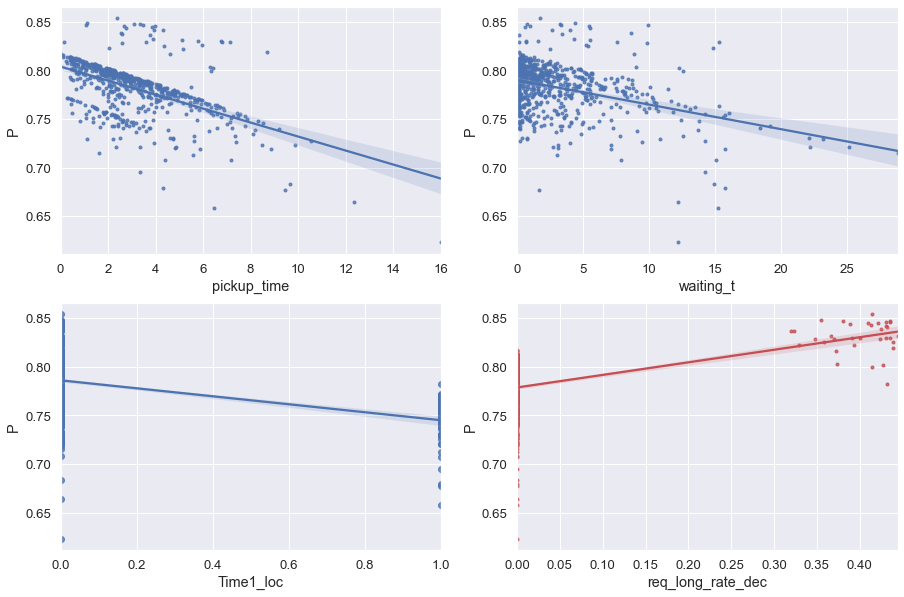

In [285]:
att = sim.acceptance_attributes
att = att[att['pickup_time']<20]
sns.set_style("darkgrid")
sns.set_palette('tab10')
sns.set(font_scale = 1.2)
df['$\delta_t$'] = df['col']
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10),)

sns.regplot(x=att['pickup_time'], y=att['P'], ax= ax[0,0], marker='.')
sns.regplot(x=att['waiting_t'], y=att['P'], ax= ax[0,1], marker='.')
sns.regplot(x=att['Time1_loc'], y=att['P'], ax= ax[1,0])
sns.regplot(x=att['req_long_rate_dec'], y=att['P'], color='r',marker='.', ax= ax[1,1])

<AxesSubplot:xlabel='number of declines', ylabel='waiting_t[sec]'>

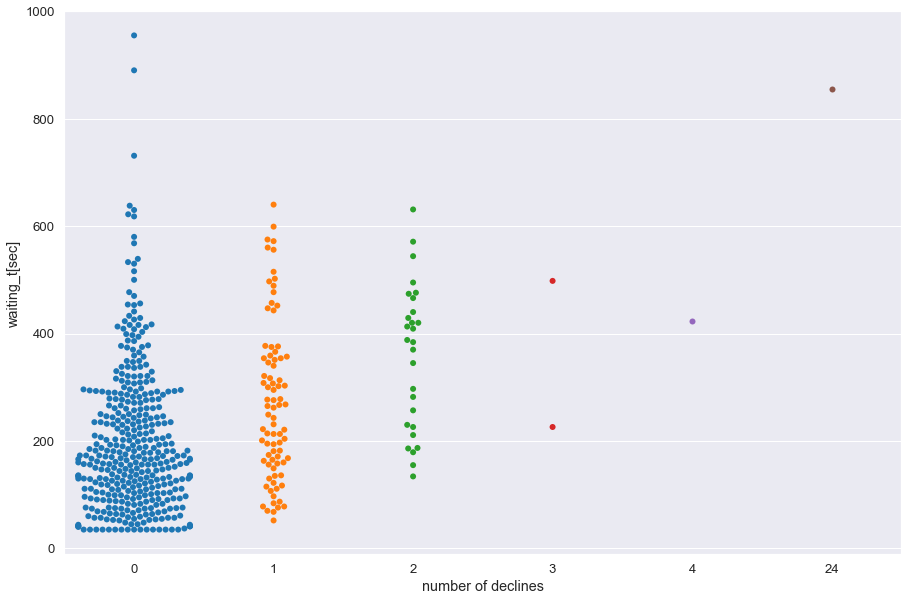

In [158]:
sns.set(font_scale = 1.2)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.set_palette('tab10')

# df = r_homo.passengers
# df['reject_t'] = df['number of declines']*10
# df['waiting_t[sec]'] = df['waiting_t[sec]'] + df['reject_t']

sns.swarmplot(x='number of declines', y='waiting_t[sec]', data=df, size=6)

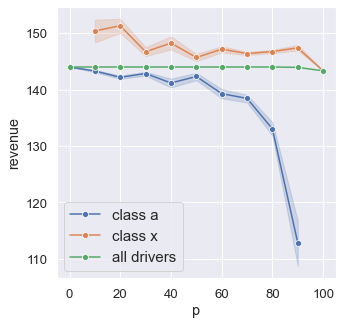

In [366]:
# I need to increase number of simulations to get a better diagram

sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(x='p', y='revenue', data=an, marker='o', ci=60)
sns.lineplot(x='p', y='revenue', data=xn, marker='o',ci=60)
sns.lineplot(x='percentage', y='mean', data=tr, marker='o')
plt.legend(labels=["class a","class x", "all drivers"], loc=3, fontsize = 15)

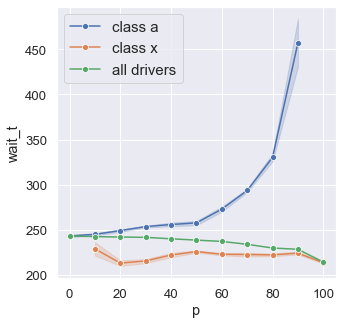

In [197]:
# I need to increase number of simulations to get a better diagram

sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(x='p', y='wait_t', data=an, marker='o', ci=60)
sns.lineplot(x='p', y='wait_t', data=xn, marker='o',ci=60)
sns.lineplot(x='percentage', y='mean', data=tw, marker='o')
plt.legend(labels=["class a","class x","all drivers"], loc=2, fontsize = 15)

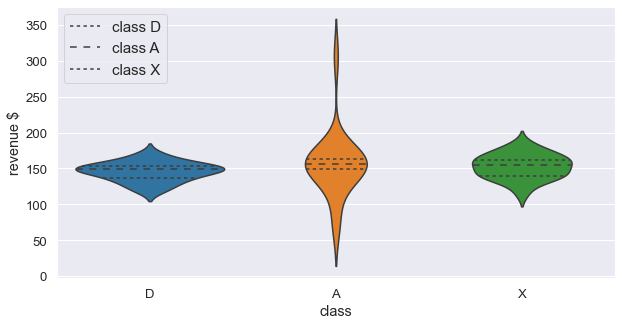

In [92]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='revenue $', data=dax,inner='quartile', palette='tab10', scale='area', bw='silverman')
plt.legend(labels=["class D","class A", "class X"], loc=2, fontsize = 15)

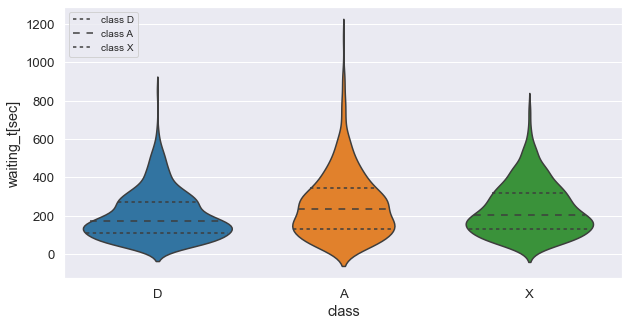

In [95]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(10,5))


sns.violinplot(x='class', y='waiting_t[sec]', data=dax, inner='quartile', palette='tab10')
plt.legend(labels=["class D","class A", "class X"], loc=2, fontsize = 10)